In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

%matplotlib inline

## Dropped Passes

In [2]:
url = 'https://scores.nbcsports.com/fb/leaders.asp?type=Receiving&range=NFL&rank=232'
res = requests.get(url)

In [3]:
res.status_code

200

In [4]:
soup = BeautifulSoup(res.content, 'lxml')

In [5]:
teams_players = soup.find_all('td', attrs={'class': ['shsNamD', 'shsNumD']})   

In [6]:
cols = ['Player', 'Team', 'Dropped_Passes']
dropped_passes = {i: [] for i in range(3)}
for i, element in enumerate(teams_players):
    txt = element.get_text()
    if i >= 3: 
        dropped_passes[i % 3].append(txt)

In [7]:
dp = pd.DataFrame({k: v for k, v in zip(cols, dropped_passes.values())})
dp.head()

,Player,Team,Dropped_Passes
0,G. Allison,GB,3
1,M. Crabtree,Bal,3
2,Z. Ertz,Phi,3
3,D. Njoku,Cle,3
4,G. Tate,Det,3


In [8]:
len(dp)

31

## Targets

In [9]:
fp_url = 'https://www.fantasypros.com/nfl/reports/targets/wr.php'

In [10]:
fp_targets = requests.get(fp_url)
fp_targets.status_code

200

In [11]:
fp_soup = BeautifulSoup(fp_targets.content, 'lxml')
tds = fp_soup.find_all('td')

In [12]:
rows = [td.get_text() for td in tds if td.get_text() != '\xa0']

In [13]:
targets = {i: [] for i in range(8)}
for i, row in enumerate(rows):
    targets[i % 8].append(row)

In [14]:
cols = ['Player', 'Team', 'Game_1', 'Game_2', 'Game_3', 'Game_4', 'Total', 'Average']
targets_df = pd.DataFrame({col: row for col, row in zip(cols, targets.values())})
targets_df.head()

,Player,Team,Game_1,Game_2,Game_3,Game_4,Total,Average
0,Nelson Agholor,PHI,10,12,5,12,39,9.8
1,Mike Wallace,PHI,3,0,0,0,3,0.8
2,DeAndre Carter,PHI,1,0,0,0,1,0.3
3,Shelton Gibson,PHI,0,2,0,0,2,0.5
4,Julio Jones,ATL,19,9,6,12,46,11.5


In [15]:
def first_initial(row):
    return f"{row.split()[0][0]}. {' '.join(row.split()[1:])}"
targets_df['Player'] = targets_df['Player'].apply(first_initial)

def custom_caps(string):
    return string.capitalize() if len(string) > 2 else string
targets_df['Team'] = targets_df['Team'].apply(custom_caps)

In [16]:
duplicates = targets_df[targets_df['Player'].duplicated(keep=False)]
duplicates.sort_values('Player').head(10)

,Player,Team,Game_1,Game_2,Game_3,Game_4,Total,Average
188,A. Robinson,Min,0,0,1,2,3,0.8
126,A. Robinson,Chi,7,14,7,4,32,8.0
102,D. Moore,Car,0,2,2,bye,4,1.3
101,D. Moore,Sea,1,0,0,2,3,0.8
93,D. Thomas,Den,10,11,5,7,33,8.3
90,D. Thomas,KC,2,0,0,2,4,1.0
98,J. Brown,Sea,3,3,3,0,9,2.3
9,J. Brown,Bal,4,10,9,7,30,7.5
75,J. Grant,Mia,7,4,3,2,16,4.0
13,J. Grant,Bal,0,0,0,0,0,0.0


In [17]:
targets_df['Total'] = targets_df['Total'].astype(int)

In [18]:
targets_df = targets_df[targets_df['Total'] >= 16]

In [19]:
targets_df.replace('Jac', 'Jax', inplace=True)
targets_df.replace('-', 0, inplace=True)

In [20]:
dropped_targets = pd.merge(dp, targets_df, on=['Player', 'Team'])

In [21]:
int_cols = dropped_targets.columns[2:-1]
dropped_targets[int_cols] = dropped_targets[int_cols].astype(int)
dropped_targets['Average'] = dropped_targets['Average'].astype(float)

In [22]:
dropped_targets['%_of_Targets_Dropped'] = (dropped_targets['Dropped_Passes']
                                           / dropped_targets['Total']) * 100

In [23]:
dt = dropped_targets.sort_values('%_of_Targets_Dropped', ascending=False)
dt.reset_index(drop=True, inplace=True)

In [24]:
dt

,Player,Team,Dropped_Passes,Game_1,Game_2,Game_3,Game_4,Total,Average,%_of_Targets_Dropped
0,L. Treadwell,Min,3,4,6,4,7,21,5.3,14.285714
1,M. Bryant,Oak,2,0,4,5,7,16,4.0,12.500000
2,R. Higgins,Cle,2,3,7,3,5,18,4.5,11.111111
3,K. Stills,Mia,2,5,3,5,6,19,4.8,10.526316
4,G. Allison,GB,3,8,6,4,11,29,7.3,10.344828
5,D. Thomas,Den,3,10,11,5,7,33,8.3,9.090909
6,D. Moncrief,Jax,2,5,9,3,5,22,5.5,9.090909
7,M. Crabtree,Bal,3,6,10,10,8,34,8.5,8.823529
8,A. Callaway,Cle,2,1,4,10,9,24,6.0,8.333333
9,P. Dorsett,NE,2,7,7,5,7,26,6.5,7.692308


In [25]:
# dt['%_of_Targets_Dropped'] = dt['%_of_Targets_Dropped'].apply(lambda x: x * 100)

In [26]:
lb = (.26, .53, .95, .8)
db = (.05, .3, .7, 1)

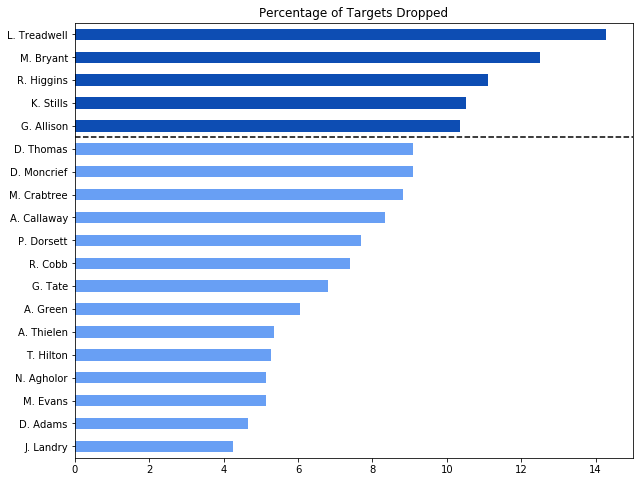

In [27]:
dt[['Player', '%_of_Targets_Dropped']][::-1].plot(
    'Player', '%_of_Targets_Dropped',
    kind='barh',
    color=[lb if i < len(dt) - 5 else db for i in range(len(dt))],
    figsize=(10, 8),
    title='Percentage of Targets Dropped',
    legend=False,)
plt.axhline(13.5, ls='--', c='k')
plt.ylabel('');

In [28]:
dt.corr()

,Dropped_Passes,Game_1,Game_2,Game_3,Game_4,Total,Average,%_of_Targets_Dropped
Dropped_Passes,1.000000,0.258011,0.281730,0.071738,0.197231,0.264145,0.234922,0.275916
Game_1,0.258011,1.000000,0.614272,0.511817,0.207501,0.815304,0.844439,-0.687047
Game_2,0.281730,0.614272,1.000000,0.345970,0.418755,0.779138,0.745603,-0.641894
Game_3,0.071738,0.511817,0.345970,1.000000,0.273609,0.760302,0.793751,-0.650932
Game_4,0.197231,0.207501,0.418755,0.273609,1.000000,0.592241,0.482116,-0.398801
Total,0.264145,0.815304,0.779138,0.760302,0.592241,1.000000,0.982731,-0.813784
Average,0.234922,0.844439,0.745603,0.793751,0.482116,0.982731,1.000000,-0.825649
%_of_Targets_Dropped,0.275916,-0.687047,-0.641894,-0.650932,-0.398801,-0.813784,-0.825649,1.000000


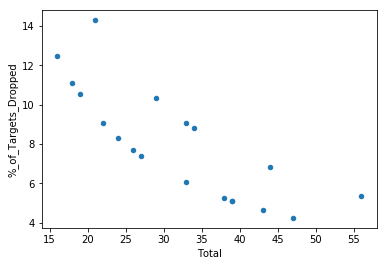

In [29]:
dt[['Total', '%_of_Targets_Dropped']].plot('Total', '%_of_Targets_Dropped', kind='scatter')

## Receptions and Catch Rate

In [61]:
new_url = 'https://www.msn.com/en-us/sports/nfl/player-stats/sp-vw-receiving'
new_res = requests.get(new_url)
new_soup = BeautifulSoup(new_res.content, 'lxml')

In [62]:
new_res.status_code

200

In [151]:
cols = [x.get_text().capitalize() for x in new_soup.find_all('th')] 
data = []
for x in new_soup.find_all('td'):
    if x.attrs:
        if 'teamtla' not in x.attrs['class']:
            data.append(x.get_text())
    else:
        data.append(x.get_text())

In [152]:
data_dict = {i: [] for i in range(len(cols))}

for i, val in enumerate(data):
    data_dict[i % len(cols)].append(val)

In [153]:
receiving = pd.DataFrame({col: row for col, row in zip(cols, data_dict.values())})

In [155]:
numerical_features = ['Rec', 'Yds', 'Long', 'Yac', 'Tds']
for col in receiving[numerical_features]:
    receiving[col] = receiving[col].astype(int)

In [156]:
receiving['Yds/rec'] = receiving['Yds/rec'].astype(float)

In [157]:
receiving['Player'] = receiving['Player'].apply(first_initial)

In [158]:
receiving.shape

(159, 9)

In [159]:
receiving[receiving.duplicated('Player', keep=False)]

,Rank,Player,Team,Rec,Yds,Yds/rec,Long,Yac,Tds
46,47,M. Williams,Chargers,12,204,17.0,42,13,3
90,91,T. Taylor,Titans,14,139,9.9,19,78,1
107,108,M. Williams,Ravens,12,119,9.9,25,71,0
147,148,T. Taylor,49ers,9,64,7.1,10,44,0


In [161]:
receiving.drop_duplicates('Player', keep=False, inplace=True)

In [164]:
receiving.drop(['Team', 'Rank'], axis=1, inplace=True)

## Merge `receiving` into `dt`

In [166]:
stats = pd.merge(dt, receiving, on='Player')

In [169]:
stats.drop(['Game_1', 'Game_2', 'Game_3', 'Game_4'], axis=1, inplace=True)

In [172]:
stats['Catch_Rate'] = (stats['Rec'] / stats['Total']) * 100

In [174]:
stats

,Player,Team,Dropped_Passes,Total,Average,%_of_Targets_Dropped,Rec,Yds,Yds/rec,Long,Yac,Tds,Catch_Rate
0,L. Treadwell,Min,3,21,5.3,14.285714,12,121,10.1,19,43,1,57.142857
1,M. Bryant,Oak,2,16,4.0,12.500000,9,111,12.3,28,60,0,56.250000
2,R. Higgins,Cle,2,18,4.5,11.111111,13,178,13.7,38,46,0,72.222222
3,K. Stills,Mia,2,19,4.8,10.526316,12,224,18.7,75,57,3,63.157895
4,G. Allison,GB,3,29,7.3,10.344828,19,289,15.2,64,101,2,65.517241
5,D. Thomas,Den,3,33,8.3,9.090909,20,168,8.4,23,79,1,60.606061
6,D. Moncrief,Jax,2,22,5.5,9.090909,12,173,14.4,67,60,2,54.545455
7,M. Crabtree,Bal,3,34,8.5,8.823529,18,184,10.2,20,27,1,52.941176
8,A. Callaway,Cle,2,24,6.0,8.333333,10,155,15.5,59,62,1,41.666667
9,P. Dorsett,NE,2,26,6.5,7.692308,16,165,10.3,20,51,2,61.538462


In [ ]:
dt[['Player', '%_of_Targets_Dropped']][::-1].plot(
    'Player', '%_of_Targets_Dropped',
    kind='barh',
    color=[lb if i < len(dt) - 5 else db for i in range(len(dt))],
    figsize=(10, 8),
    title='Percentage of Targets Dropped',
    legend=False,)
plt.axhline(13.5, ls='--', c='k')
plt.ylabel('');

## Saving Our Work

In [30]:
dt.to_csv('pct_targets_dropped.csv', index=False)